# Diving in deeper

In [13]:
import logging
import sys
from dataclasses import asdict

import pandas as pd
from dotenv import load_dotenv
from tqdm.contrib.concurrent import thread_map
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import re, spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm.auto import tqdm
import torch
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display

from wggesuchtstats.scraper import get_flat_details

# logging.getLogger("backoff").setLevel(logging.WARNING) 
logging.getLogger("urllib3.connectionpool").setLevel(logging.WARNING)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

tqdm.pandas()
load_dotenv()

False

## Get the data

In [ ]:
# --- Load & fix URLs ---
df = pd.read_csv("../data/flat_ads.csv").reset_index(drop=True)
df["url"] = df["url"].apply(
    lambda u: u if str(u).startswith("http") else f"https://www.wg-gesucht.de/{str(u).lstrip('/')}"
)


df["details"] = thread_map(
    get_flat_details,
    df["url"].tolist(),
    max_workers=64,
    desc="Fetching ads",
    chunksize=1,
)

# --- Expand dataclass fields ---
details_df = df["details"].apply(lambda d: asdict(d) if d is not None else {})
df = df.join(pd.json_normalize(details_df)).drop(columns=["details"])

# --- Save ---
df.to_csv("../data/flat_ads_with_details_new.csv", index=False, encoding="utf-8")
len(df)


Fetching ads: 100%|██████████| 1766/1766 [07:59<00:00,  3.68it/s]


In [2]:
df = pd.read_csv("../data/flat_ads_with_details.csv")
df.head()

,url,published,rent,size,district,female_inhabitants,male_inhabitants,diverse_inhabitants,total_inhabitants,headline,description,street,zip_code,available_from,available_until,age_min,age_max
0,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,2025-08-16T00:00:00,550,16,Prenzlauer Berg,1,0,0,2,NUR Berufstätige/Praktikanten: 2-er WG in Pre...,"16qm,3m Zimmerhöhe, Südosten, 4.OG, sehr hell ...",Danziger Str,10407.0,2025-09-01,2025-12-01,49.0,49.0
1,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,2025-08-16T00:00:00,999,20,Prenzlauer Berg,1,1,0,4,URBANELITE.COM // Keine Kaution! (keine Absich...,- > WWW. URBANELITE.COM \n\n WIR ARE: \n Wir s...,Schönhauser Allee,10439.0,2025-08-16,NaN,NaN,NaN
2,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,2025-08-16T00:00:00,650,20,Prenzlauer Berg,0,1,0,2,Bright Room for Sublet in Prenzlauer Berg (6 M...,Ich biete meine ca. 20 m2 Zimmer in einer reno...,Dunckerstraße,10439.0,2025-10-01,2026-03-31,35.0,40.0
3,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,2025-08-15T00:00:00,750,16,Friedrichshain,0,1,0,2,Gemütliches Sonnenzimmer in Fshain,Mieten Mein schön sonniges Zimmer – 2 Monate (...,Bosestraße 6A,10245.0,2025-09-01,2026-04-01,30.0,36.0
4,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,2025-07-14T00:00:00,900,20,Kreuzberg,1,0,0,2,WG room 20m2 Mehringdamm,Zimmer verfügbar ab September. \n Letztendlich...,Großbeerenstraße 28,10965.0,2025-08-15,NaN,28.0,28.0


In [3]:
df = df[df["headline"].notna()] 
len(df)

3747

## Age

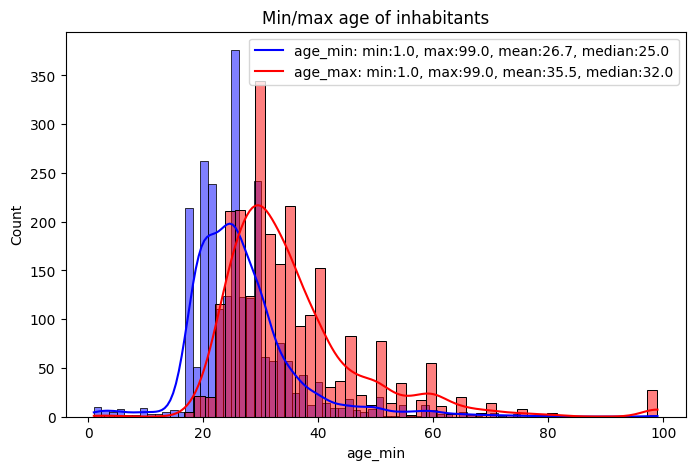

In [7]:
def get_stats(series):
    return {
        "min": series.min(),
        "max": series.max(),
        "mean": series.mean(),
        "median": series.median()
    }

age_min_stats = get_stats(df["age_min"].dropna())
age_max_stats = get_stats(df["age_max"].dropna())

# Histogram with legend showing stats
plt.figure(figsize=(8,5))
sns.histplot(df["age_min"], color="blue", kde=True, alpha=0.5, label="age_min")
sns.histplot(df["age_max"], color="red", kde=True, alpha=0.5, label="age_max")

# Add stats to legend
legend_text = [
    f"age_min: min:{age_min_stats['min']}, max:{age_min_stats['max']}, "
    f"mean:{age_min_stats['mean']:.1f}, median:{age_min_stats['median']}",
    f"age_max: min:{age_max_stats['min']}, max:{age_max_stats['max']}, "
    f"mean:{age_max_stats['mean']:.1f}, median:{age_max_stats['median']}"
]

plt.legend(legend_text)
plt.title("Min/max age of inhabitants")
plt.show()

C:\Users\Yannik\AppData\Local\Temp\ipykernel_12704\2865640186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["cluster"] = kmeans.fit_predict(X)
C:\Users\Yannik\AppData\Local\Temp\ipykernel_12704\2865640186.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["cluster_name"] = df_cleaned["cluster"].map(cluster_names)


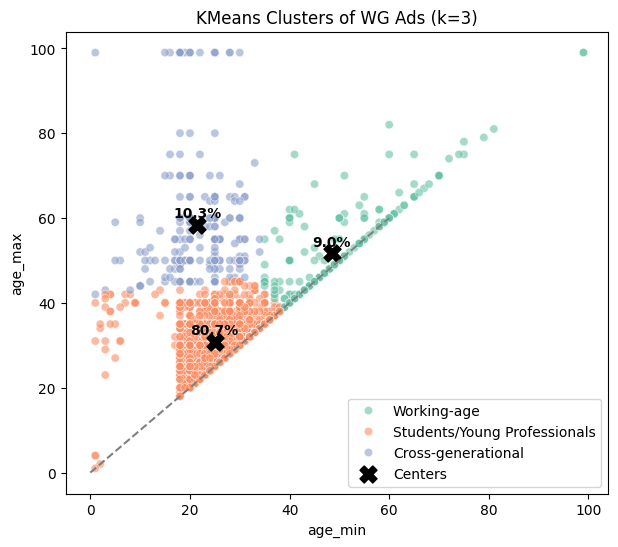

In [21]:
df_cleaned = df.dropna(subset=["age_min","age_max"])
X = df_cleaned[["age_min","age_max"]]

# --- Fit KMeans ---
best_k = 3  # <- set this after elbow method
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df_cleaned["cluster"] = kmeans.fit_predict(X)

cluster_names = {
    0: "Students/Young Professionals",
    1: "Cross-generational",
    2: "Working-age"
}

# Map numeric cluster labels to names
df_cleaned["cluster_name"] = df_cleaned["cluster"].map(cluster_names)

# --- Cluster sizes ---
cluster_counts = df_cleaned["cluster"].value_counts(normalize=True).sort_index() * 100

# --- Scatterplot ---
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_cleaned, x="age_min", y="age_max", hue="cluster_name", palette="Set2", alpha=0.6)

# cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c="black", s=150, marker="X", label="Centers")

# annotate percentages
for idx, (x, y) in enumerate(centers):
    pct = cluster_counts[idx]
    plt.text(x, y+1, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")

plt.plot([0,60],[0,60], color="gray", linestyle="--")
plt.xlabel("age_min")
plt.ylabel("age_max")
plt.title(f"KMeans Clusters of WG Ads (k={best_k})")
plt.legend()
plt.show()

## NLP

In [4]:
df["text"] = (df["headline"].fillna("") + " " + df["description"].fillna("")).str.strip()
df_nlp = df[df["text"].str.len() > 0].copy()

In [19]:


nlp = spacy.load("de_core_news_sm", disable=["parser"])
STOP_EXTRA = set(line.strip() for line in open("../data/stop_words.txt", encoding="utf-8"))

def clean_txt(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[\d_]+", " ", s)
    return s.strip()

df_nlp["text_clean"] = df_nlp["text"].progress_apply(clean_txt)
texts = df_nlp["text_clean"].tolist()
lemmas = []
for doc in tqdm(nlp.pipe(texts, batch_size=64), total=len(texts), desc="lemmatizing"):
    toks = [
        t.lemma_.lower()
        for t in doc
        if t.is_alpha and not t.is_stop and len(t.lemma_) >= 3 and t.lemma_.lower() not in STOP_EXTRA
    ]
    lemmas.append(" ".join(toks))

df_nlp["text_lem"] = lemmas

lemmatizing: 100%|██████████| 3747/3747 [04:03<00:00, 15.38it/s]


In [16]:
def top_tfidf_terms(texts, n=20, ngram=(1,1), min_df=5, max_df=0.6):
    v = TfidfVectorizer(ngram_range=ngram, min_df=min_df, max_df=max_df)
    X = v.fit_transform(texts)
    mean_scores = np.asarray(X.mean(axis=0)).ravel()
    idx = mean_scores.argsort()[::-1][:n]
    return pd.DataFrame({"term": np.array(v.get_feature_names_out())[idx],
                         "tfidf": mean_scores[idx]})

top_uni = top_tfidf_terms(df_nlp["text_lem"], n=25, ngram=(1,1))
top_bi  = top_tfidf_terms(df_nlp["text_lem"], n=25, ngram=(2,2))
print(top_uni.head(10)); print(top_bi.head(10))

       term     tfidf
0     ruhig  0.028846
1     schön  0.027227
2     küche  0.022431
3    balkon  0.021267
4    liegen  0.021082
5    direkt  0.020641
6    suchen  0.020607
7    person  0.019227
8  befinden  0.018281
9  entfernt  0.017532
                        term     tfidf
0            prenzlauer berg  0.012642
1            fully furnished  0.007785
2                  küche bad  0.007551
3             voll möblieren  0.007408
4  öffentlich verkehrsmittel  0.007113
5          voll ausgestattet  0.007092
6          bett schreibtisch  0.007062
7         ausgestattet küche  0.006857
8           tempelhofer feld  0.006396
9                hoch decken  0.006232


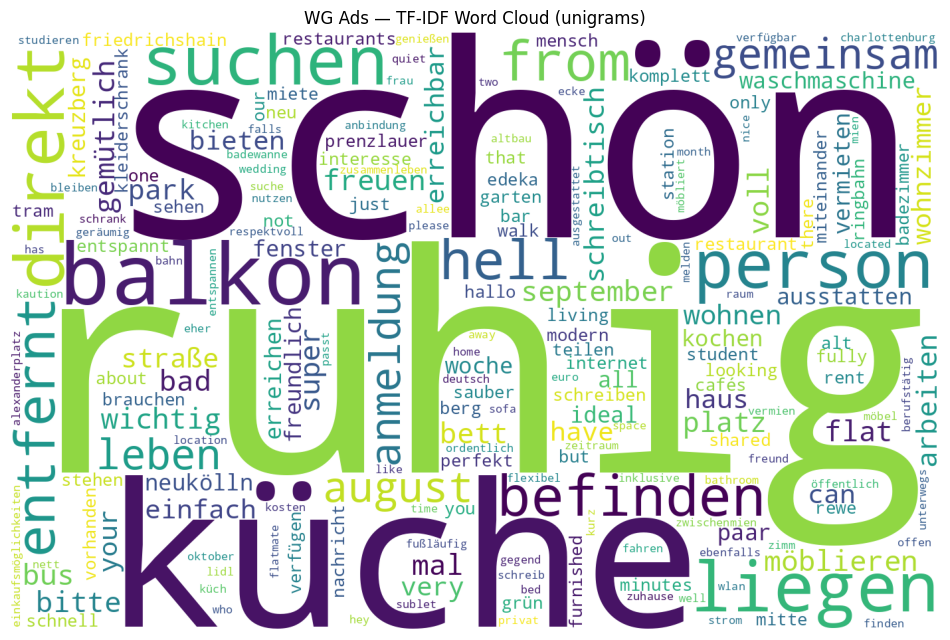

In [21]:
stopword_list = STOPWORDS.union(STOP_EXTRA)

# TF-IDF → mean weight per term
v = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df=0.6)
X = v.fit_transform(df_nlp["text_lem"])
weights = np.asarray(X.mean(axis=0)).ravel()
terms = v.get_feature_names_out()
freq = {t: float(w) for t, w in zip(terms, weights)}

wc = WordCloud(width=1400, height=900, background_color="white", stopwords=stopword_list)
img = wc.generate_from_frequencies(freq)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis("off")
plt.title("WG Ads — TF-IDF Word Cloud (unigrams)")
plt.show()

In [17]:
def lsa_topics(texts, n_topics=8, n_terms=10, min_df=5, max_df=0.6, ngram=(1,2)):
    v = TfidfVectorizer(ngram_range=ngram, min_df=min_df, max_df=max_df)
    X = v.fit_transform(texts)
    svd = TruncatedSVD(n_components=n_topics, random_state=42)
    W = svd.fit_transform(X)
    H = svd.components_
    terms = v.get_feature_names_out()
    topics = []
    for k in range(n_topics):
        idx = np.argsort(H[k])[::-1][:n_terms]
        topics.append({"topic": k, "terms": ", ".join(terms[i] for i in idx)})
    doc_topics = W.argmax(axis=1)
    return pd.DataFrame(topics), pd.Series(doc_topics, name="topic")

topics_df, df_nlp["topic_lsa"] = lsa_topics(df_nlp["text_lem"], n_topics=6, n_terms=12)
print(topics_df)


   topic                                              terms
0      0  ruhig, schön, küche, from, direkt, suchen, per...
1      1  our, your, flat, from, can, community, have, t...
2      2  community, our, hinaus, netzwerk, network, mor...
3      3  mal, wichtig, leben, that, mensch, but, kochen...
4      4  prenzlauer, berg, prenzlauer berg, allee, schö...
5      5  august, neukölln, september, kreuzberg, schön,...


In [20]:
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
emb = model.encode(texts, show_progress_bar=True, normalize_embeddings=True)

um = umap.UMAP(n_neighbors=15, min_dist=0.05, n_components=2, random_state=42)
xy = um.fit_transform(emb)

cl = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, metric="euclidean").fit(emb)
df_nlp["cluster_hdb"] = cl.labels_  # -1 = noise

# Inspect clusters
print(df_nlp["cluster_hdb"].value_counts().head(10))

2025-08-19 14:25:55,237 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-08-19 14:25:55,239 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


Batches: 100%|██████████| 118/118 [04:04<00:00,  2.07s/it]
c:\Users\Yannik\AppData\Local\pypoetry\Cache\virtualenvs\wggesuchtstats-9Efq763c-py3.12\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Yannik\AppData\Local\pypoetry\Cache\virtualenvs\wggesuchtstats-9Efq763c-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Yannik\AppData\Local\pypoetry\Cache\virtualenvs\wggesuchtstats-9Efq763c-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster_hdb
 0    2632
-1    1075
 1      40
Name: count, dtype: int64


In [21]:
def cluster_keywords(texts, labels, topn=12):
    out = []
    for lab in sorted(set(labels)):
        if lab == -1: continue
        subset = [t for t,l in zip(texts, labels) if l == lab]
        tt = top_tfidf_terms(subset, n=topn, ngram=(1,2))
        out.append((lab, ", ".join(tt.term.tolist())))
    return pd.DataFrame(out, columns=["cluster","keywords"])
    
print(cluster_keywords(df_nlp["text_lem"].tolist(), df_nlp["cluster_hdb"].tolist()))

   cluster                                           keywords
0        0  ruhig, schön, küche, liegen, balkon, direkt, s...
1        1  friedrichshain, kreuzberg, friedrichshain idea...


In [10]:
MODEL = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
torch.set_num_threads(3)
device = 0 if torch.cuda.is_available() else -1

tok = AutoTokenizer.from_pretrained(MODEL)
mdl = AutoModelForSequenceClassification.from_pretrained(MODEL)
pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, device=device, return_all_scores=True)

def fast_sentiment(texts, batch_size=64, max_len=256, desc="Sentiment"):
    labels, scores = [], []
    n_batches = (len(texts) + batch_size - 1) // batch_size
    for i in tqdm(range(n_batches), desc=desc):
        batch = texts[i*batch_size:(i+1)*batch_size]
        out = pipe(batch, truncation=True, max_length=max_len)
        for row in out:
            best = max(row, key=lambda x: x["score"])
            labels.append(best["label"].lower())
            scores.append(float(best["score"]))
    return labels, scores

df_nlp["sentiment"], df_nlp["sentiment_score"] = fast_sentiment(df_nlp["text"].tolist())

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


2025-08-19 16:08:27,175 - huggingface_hub.file_download - WARNING - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Device set to use cpu
c:\Users\Yannik\AppData\Local\pypoetry\Cache\virtualenvs\wggesuchtstats-9Efq763c-py3.12\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Sentiment: 100%|██████████| 59/59 [21:20<00:00, 21.70s/it]


In [11]:
df_nlp["sentiment"].value_counts(normalize=True).mul(100).round(1)


sentiment
positive    82.7
negative    16.2
neutral      1.1
Name: proportion, dtype: float64

In [17]:
pd.set_option("display.max_colwidth", None)  # no truncation

# get most positive (highest score where label=positive)
pos = df_nlp[df_nlp["sentiment"]=="positive"].sort_values("sentiment_score", ascending=False).head(5)

# get most negative (highest score where label=negative)
neg = df_nlp[df_nlp["sentiment"]=="negative"].sort_values("sentiment_score", ascending=False).head(5)

# select just relevant fields
compare = pd.DataFrame({
    "Most Positive": pos["text"].values,
    "Most Negative": neg["text"].values
})

display(compare)


Most Positive  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     schönes WG- Zimmer in Berlin Prenzlauerberg, befristet schönes, helles Zimmer in Berlin Prenzlauer Berg mit Balkon   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Room in Prenzlauer Berg Very nice and bright room, king size bed, plants, table and balcony\nVery well located in the lively neighborhood of Prenzlauer Berg\nKitchen   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
def quick_ner_counts(texts, topn=20):
    cats = []
    for doc in nlp.pipe(texts, batch_size=64):
        for e in doc.ents:
            if e.label_ in {"LOC","PER","ORG","MISC","DATE","MONEY"}:
                cats.append((e.text.lower(), e.label_))
    s = pd.DataFrame(cats, columns=["ent","label"]).value_counts().reset_index(name="count")
    return s.groupby("label").head(topn)
    
ner_top = quick_ner_counts(df_nlp["text"].head(5000))  # sample for speed
print(ner_top.head(15))